# <b>Price Prediction using XGBOOST

In [93]:
import numpy as np
import pandas as pd
import matplotlib
import yfinance as yf

In [94]:
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#S%26P_500_component_stocks')
table_symbol = data[0]
table_industry = data[0]['GICS Sector']

#these 2 lists are in order with one another
symbols = list(table_symbol.Symbol.values)
industries = list(table_industry.values) ##Industry Sector

remove = []

symbols_to_remove = ['BF.B', 'BRK.B', 'KVUE', 'VLTO','SPY']

for i, symbol in enumerate(symbols):
    if symbol in symbols_to_remove:
        remove.append(i)

for i in remove:
    symbols.remove(symbols[i])
    industries.remove(industries[i])

print(len(symbols))

symbol_industry = dict(zip(symbols,industries))
print(len(symbol_industry))

499
499


In [95]:
tickers = yf.Tickers('AAPL')

APPLdf = tickers.tickers['AAPL'].history(period="5d", start="2022-01-01", end="2022-12-31")
APPLdf.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-03 00:00:00-05:00,175.821100,180.814055,175.702461,179.953873,104487900,0.0,0.0
2022-01-04 00:00:00-05:00,180.566891,180.873387,177.096533,177.669983,99310400,0.0,0.0
2022-01-05 00:00:00-05:00,177.581022,178.134693,172.667164,172.944000,94537600,0.0,0.0
2022-01-06 00:00:00-05:00,170.749035,173.319669,169.701012,170.056946,96904000,0.0,0.0
2022-01-07 00:00:00-05:00,170.936904,172.172783,169.097916,170.225037,86709100,0.0,0.0
2022-01-10 00:00:00-05:00,167.169959,170.551323,166.270236,170.244827,106765600,0.0,0.0
2022-01-11 00:00:00-05:00,170.373372,173.201049,168.890317,173.102188,76138300,0.0,0.0
2022-01-12 00:00:00-05:00,174.130435,175.178458,172.845133,173.547104,74805200,0.0,0.0
2022-01-13 00:00:00-05:00,173.794269,174.624776,169.849337,170.244827,84505800,0.0,0.0


In [96]:
drop_cols = ['Open', 'Low', 'High','Volume', 'Dividends', 'Stock Splits']
APPLdf = APPLdf.drop(columns=drop_cols, axis = 1)
APPLdf.index = APPLdf.index.astype(str).str.split(' ').str[0]
APPLdf

,Close
Date,
2022-01-03,179.953873
2022-01-04,177.669983
2022-01-05,172.944000
2022-01-06,170.056946
2022-01-07,170.225037
...,...
2022-12-23,131.127060
2022-12-27,129.307251
2022-12-28,125.339417


In [97]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows=1, cols=1, subplot_titles=('Price of APPL for 2022',))

# Add trace for Close price
fig.add_trace(go.Scatter(x=APPLdf.index, y=APPLdf['Close'], name='Close Price'), row=1, col=1)

# Get unique months in the DataFrame
unique_months = pd.to_datetime(APPLdf.index).to_period('M').unique()

# Update x-axis layout to show ticks for each month
fig.update_xaxes(
    tickmode='array',
    tickvals=unique_months.to_timestamp(),  # Convert to timestamp for plotting
    ticktext=unique_months.strftime('%b'),  # Displaying abbreviated month names
)
# Show figure
fig.show()

In [98]:
holidays = ["2022-01-17","2022-02-21","2022-04-15", "2022-05-30", "2022-06-20", "2022-07-4", "2022-09-5", "2022-11-24","2022-12-26"]
len(holidays)

9

In [99]:
holiday_df = pd.DataFrame(index=holidays)
holiday_df['Date'] = holiday_df.index

# Add another column 'Close' with NaN values
holiday_df['Close'] = float('nan')

# Set the 'Date' column as the index
holiday_df.set_index('Date', inplace=True)

# Print the resulting DataFrame
holiday_df

,Close
Date,
2022-01-17,NaN
2022-02-21,NaN
2022-04-15,NaN
2022-05-30,NaN
2022-06-20,NaN
2022-07-4,NaN
2022-09-5,NaN
2022-11-24,NaN
2022-12-26,NaN


In [100]:
APPLdf.loc["2022-11-25"]

Close    147.286728
Name: 2022-11-25, dtype: float64

In [101]:
# Assuming APPLdf and holiday_df are DataFrames

# Concatenate the original DataFrame with the holiday DataFrame
frames = [APPLdf, holiday_df]
result_df = pd.concat(frames)

# Convert the index to a consistent data type (e.g., Timestamp)
result_df.index = pd.to_datetime(result_df.index)

# Sort the index to maintain order
result_df = result_df.sort_index()

# Print the resulting DataFrame
APPL1 = result_df
APPL1


,Close
Date,
2022-01-03,179.953873
2022-01-04,177.669983
2022-01-05,172.944000
2022-01-06,170.056946
2022-01-07,170.225037
...,...
2022-12-26,NaN
2022-12-27,129.307251
2022-12-28,125.339417


In [102]:
# Convert index to datetime if it's in string format
APPL1.index = pd.to_datetime(APPL1.index)

# Create a new DataFrame with the desired structure
new_df = pd.DataFrame(index=[f'APPL Week {week}' for week in range(1, 53)],
                      columns=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5'])

# Iterate through rows of the original DataFrame and fill the new DataFrame
for i, row in APPL1.iterrows():
    week = i.week
    day = i.dayofweek
    
    # If there are rows for the current week and day, set the mean close price
    if not pd.isna(row['Close']):
        new_df.at[f'APPL Week {week}', f'Day {day + 1}'] = row['Close']

# Display the new DataFrame
APPL = new_df
nan_rows = new_df[new_df.isna().any(axis=1)]
nan_rows

,Day 1,Day 2,Day 3,Day 4,Day 5
APPL Week 3,NaN,167.881836,164.352142,162.651581,160.575317
APPL Week 8,NaN,162.670746,158.463379,161.106598,163.195419
APPL Week 15,164.08638,165.977203,168.689667,163.630997,NaN
APPL Week 22,NaN,147.562576,147.433716,149.912262,144.132278
APPL Week 25,NaN,134.703888,134.18837,137.083298,140.444229
APPL Week 27,NaN,140.345062,141.69339,145.093964,145.77803
APPL Week 36,NaN,153.41655,154.836258,153.347076,156.236084
APPL Week 47,147.187286,149.345215,150.230301,NaN,147.286728
APPL Week 52,NaN,129.307251,125.339417,128.889572,129.207779


In [103]:
# Convert index to datetime if it's in string format
APPL1.index = pd.to_datetime(APPL1.index)

# Create a new DataFrame with the desired structure
new_df = pd.DataFrame(index=[f'APPL Week {week}' for week in range(1, 53)],
                      columns=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5'])

# Iterate through rows of the original DataFrame and fill the new DataFrame
for i, row in APPL1.iterrows():
    week = i.week
    day = i.dayofweek
    
    # If there are rows for the current week and day, set the mean close price
    if not pd.isna(row['Close']):
        new_df.at[f'APPL Week {week}', f'Day {day + 1}'] = row['Close']

# Drop rows with NaN values
new_df = new_df.dropna()

# Display the new DataFrame
APPL = new_df
APPL = APPL.drop(['APPL Week 1'], axis=0)
APPL


,Day 1,Day 2,Day 3,Day 4,Day 5
APPL Week 2,170.244827,173.102188,173.547104,170.244827,171.114914
APPL Week 4,159.79425,157.975006,157.886032,157.421356,168.405853
APPL Week 5,172.805557,172.637497,173.853592,170.946793,170.659714
APPL Week 6,169.937027,173.075241,174.510666,170.392441,166.947357
APPL Week 7,167.184967,171.055725,170.81813,167.184967,165.620819
APPL Week 9,163.462692,161.561966,164.888229,164.561554,161.532272
APPL Week 10,157.701111,155.859787,161.314484,156.928925,153.176971
APPL Week 11,149.108215,153.533371,157.988174,159.007828,162.334137
APPL Week 12,163.720093,167.125549,168.501587,172.322876,172.966339
APPL Week 13,173.837509,177.163788,175.985733,172.857452,172.56044


In [104]:
APPLPCT1 = APPL1.pct_change()
APPLPCT1

/var/folders/bq/q6bbfq_s68l_m1x6yxgvqnt80000gn/T/ipykernel_3385/1966763988.py:1: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.



,Close
Date,
2022-01-03,NaN
2022-01-04,-0.012692
2022-01-05,-0.026600
2022-01-06,-0.016694
2022-01-07,0.000988
...,...
2022-12-26,0.000000
2022-12-27,-0.013878
2022-12-28,-0.030685


In [105]:
# Convert index to datetime if it's in string format
APPLPCT1.index = pd.to_datetime(APPL1.index)

# Create a new DataFrame with the desired structure
new_df = pd.DataFrame(index=[f'APPL PC Week {week}' for week in range(1, 53)],
                      columns=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5'])

# Iterate through rows of the original DataFrame and fill the new DataFrame
for i, row in APPLPCT1.iterrows():
    week = i.week
    day = i.dayofweek
    
    # If there are rows for the current week and day, set the mean close price
    if not pd.isna(row['Close']):
        new_df.at[f'APPL PC Week {week}', f'Day {day + 1}'] = row['Close']

new_df.replace(0, pd.NA, inplace=True)

# Drop rows with NaN values
new_df = new_df.dropna()

# Display the new DataFrame
APPLPCT = new_df
APPLPCT

,Day 1,Day 2,Day 3,Day 4,Day 5
APPL PC Week 2,0.000116,0.016784,0.002570,-0.019028,0.005111
APPL PC Week 4,-0.004864,-0.011385,-0.000563,-0.002943,0.069778
APPL PC Week 5,0.026126,-0.000973,0.007044,-0.01672,-0.001679
APPL PC Week 6,-0.004235,0.018467,0.008294,-0.023599,-0.020219
APPL PC Week 7,0.001423,0.023153,-0.001389,-0.021269,-0.009356
APPL PC Week 9,0.001638,-0.011628,0.020588,-0.001981,-0.018408
APPL PC Week 10,-0.023718,-0.011676,0.034997,-0.027186,-0.023909
APPL PC Week 11,-0.026562,0.029677,0.029015,0.006454,0.020919
APPL PC Week 12,0.008538,0.020800,0.008234,0.022678,0.003734
APPL PC Week 13,0.005037,0.019134,-0.006650,-0.017776,-0.001718


In [106]:
all = pd.DataFrame(columns=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5'])

# Iterate through each symbol
for symbol in symbols:
    # Fetch historical stock data for the symbol
    ticker = yf.Ticker(symbol)
    stock_data = ticker.history(period="1y")  # Fetch data for the last 1 year

    # Extract the close prices for each week
    for week in range(1, 53):
        start_date = f"2022-01-01"  # Change the start date as needed
        end_date = f"2022-12-31"    # Change the end date as needed
        week_data = stock_data[start_date:end_date]

        # If data for the current week is missing, create a row with NaN values
        if len(week_data) < 5:
            week_row = pd.DataFrame([[np.nan] * 5], columns=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5'],
                                     index=[f'{symbol} Week {week}'])
        else:
            week_row = pd.DataFrame([week_data['Close'].tolist()[:5]], columns=['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5'],
                                     index=[f'{symbol} Week {week}'])

        # Concatenate the temporary DataFrame with the result DataFrame
        all = pd.concat([all, week_row])

# Display the resulting DataFrame
all

/var/folders/bq/q6bbfq_s68l_m1x6yxgvqnt80000gn/T/ipykernel_3385/2891734177.py:24: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

BF.B: No price data found, symbol may be delisted (period=1y)


,Day 1,Day 2,Day 3,Day 4,Day 5
MMM Week 1,118.807487,119.750473,117.525024,117.477882,119.146957
MMM Week 2,118.807487,119.750473,117.525024,117.477882,119.146957
MMM Week 3,118.807487,119.750473,117.525024,117.477882,119.146957
MMM Week 4,118.807487,119.750473,117.525024,117.477882,119.146957
MMM Week 5,118.807487,119.750473,117.525024,117.477882,119.146957
...,...,...,...,...,...
ZTS Week 48,155.224060,155.997009,153.925903,151.666519,148.891815
ZTS Week 49,155.224060,155.997009,153.925903,151.666519,148.891815
ZTS Week 50,155.224060,155.997009,153.925903,151.666519,148.891815
ZTS Week 51,155.224060,155.997009,153.925903,151.666519,148.891815


In [107]:
all.iloc[1::52]

,Day 1,Day 2,Day 3,Day 4,Day 5
MMM Week 2,118.807487,119.750473,117.525024,117.477882,119.146957
AOS Week 2,59.386421,59.288231,58.738358,58.296494,58.198303
ABT Week 2,105.813217,105.970070,103.342636,101.823044,102.754402
ABBV Week 2,155.354019,157.305176,157.574310,157.362839,158.977615
ACN Week 2,298.093933,295.436157,288.161713,280.946381,282.206390
...,...,...,...,...,...
YUM Week 2,126.804100,127.285049,128.492325,128.207672,125.901093
ZBRA Week 2,268.820007,274.859985,261.799988,254.210007,252.539993
ZBH Week 2,122.412201,122.035088,121.350327,120.467094,123.245811
ZION Week 2,49.511326,49.758923,46.111523,44.892551,44.806843


In [108]:
tickers = yf.Tickers('MMM')

MMMdf = tickers.tickers['MMM'].history(period="5d", start="2022-01-01", end="2022-12-31")
drop_cols = ['Open', 'Low', 'High','Volume', 'Dividends', 'Stock Splits']
MMMdf = MMMdf.drop(columns=drop_cols, axis = 1)
MMMdf.index = MMMdf.index.astype(str).str.split(' ').str[0]
frames = [MMMdf, holiday_df]
result_df = pd.concat(frames)

# Convert the index to a consistent data type (e.g., Timestamp)
#result_df.index = pd.to_datetime(result_df.index)

# Sort the index to maintain order
result_df = result_df.sort_index()

# Print the resulting DataFrame
MMM1 = result_df
MMM1
pct = MMM1.ffill().pct_change()
pct

,Close
Date,
2022-01-03,NaN
2022-01-04,0.014009
2022-01-05,-0.004106
2022-01-06,-0.008301
2022-01-07,0.010955
...,...
2022-12-26,0.000000
2022-12-27,0.000666
2022-12-28,-0.016054


In [109]:
pct = MMM1.ffill().pct_change()
pct

,Close
Date,
2022-01-03,NaN
2022-01-04,0.014009
2022-01-05,-0.004106
2022-01-06,-0.008301
2022-01-07,0.010955
...,...
2022-12-26,0.000000
2022-12-27,0.000666
2022-12-28,-0.016054


In [110]:
# Get the list of S&P 500 stocks
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = sp500['Symbol'].tolist()
#removal = ['BF.B', 'KVUE', 'VLTO', 'BRK.B']

# Remove specified tickers from the list
#sp500_tickers = [ticker for ticker in sp500_tickers if ticker not in removal]
# Function to fetch data and create price percentage DataFrame
def get_price_percentage_df(ticker):
    try:
        stock_data = yf.download(ticker, start="2022-01-01", end="2022-12-31")
        drop_cols = ['Open', 'Low', 'High', 'Adj Close', 'Volume']
        stock_data = stock_data.drop(columns=drop_cols, axis=1)
        stock_data.index = stock_data.index.astype(str).str.split(' ').str[0]
        result_df = stock_data.ffill().pct_change()
        result_df.columns = [f"{ticker}" for col in result_df.columns]
        return result_df
    
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()

In [111]:

# Fetch data for each ticker and create price percentage DataFrame
pct_dfs = []
for ticker in sp500_tickers:
        pct_df = get_price_percentage_df(ticker)
        if not pct_df.empty:
            pct_dfs.append(pct_df)

# Concatenate the DataFrames
sp500_pct_df = pd.concat(pct_dfs, axis=1)

# Display the resulting DataFrame
sp500_pct_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-01-01 -> 2022-12-31)')



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['KVUE']: Exception("%ticker%: Data doesn't exist for startDate = 1641013200, endDate = 1672462800")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******


1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1641013200, endDate = 1672462800")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

,MMM,AOS,ABT,ABBV,ACN,ADM,ADBE,ADP,AES,AFL,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,0.014009,0.016633,-0.023518,-0.001920,-0.007146,0.018559,-0.018374,0.004672,0.002871,0.032778,...,0.013160,0.020129,-0.003190,0.006329,0.010608,0.005347,0.006337,0.010145,0.028487,-0.038072
2022-01-05,-0.004106,-0.016714,-0.004493,0.005253,-0.017611,-0.007809,-0.071426,-0.008525,-0.045808,-0.001662,...,-0.006955,-0.023287,-0.037033,0.009800,-0.013629,-0.012677,-0.050068,-0.003297,0.002270,-0.038024
2022-01-06,-0.008301,0.006703,-0.000148,-0.004710,-0.048290,0.008891,-0.000603,-0.006871,-0.003858,0.018475,...,-0.011265,0.003502,0.004629,-0.007822,-0.001373,0.010331,-0.005410,-0.008307,0.041075,0.003971
2022-01-07,0.010955,-0.011296,0.003108,-0.002588,-0.019180,0.008523,-0.006652,-0.010564,-0.006024,0.015852,...,-0.011863,-0.008802,-0.001063,0.008759,-0.007992,-0.011466,-0.043771,-0.006050,0.016681,-0.029114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,-0.011925,0.011915,0.001389,-0.001041,0.005023,0.012087,0.005735,0.007443,0.013070,0.011846,...,0.008626,0.006644,-0.006401,0.012852,-0.000728,0.000621,0.002869,-0.000789,0.003521,0.005033
2022-12-27,0.000666,0.013532,0.003605,-0.000674,-0.002931,0.013633,-0.009928,0.000374,0.004881,0.006829,...,0.000777,0.000407,0.044723,0.009023,0.009022,0.007758,0.011200,0.004657,0.008050,-0.003156
2022-12-28,-0.016054,-0.015606,-0.006816,-0.004663,-0.008255,-0.023877,-0.020174,-0.013193,-0.017349,-0.010659,...,-0.011612,-0.014629,-0.050279,-0.013972,-0.016077,-0.004542,-0.016574,-0.010135,-0.017813,-0.010117


In [112]:
#sp500_pct_df

In [113]:
holidays = ["2022-01-17","2022-02-21","2022-04-15", "2022-05-30", "2022-06-20", "2022-07-4", "2022-09-5", "2022-11-24","2022-12-26"]
columns = sp500_pct_df.columns

# Create holiday_df with NaN values for each date and columns matching sp500_pct_df
holiday_df = pd.DataFrame(index=holidays, columns=columns)
holiday_df['Date'] = holiday_df.index

# Set the 'Date' column as the index
holiday_df.set_index('Date', inplace=True)
holiday_df.shape

(9, 499)

In [114]:
result_df = pd.concat([sp500_pct_df, holiday_df], axis=0)
# Sort the DataFrame by index to maintain order
result_df = result_df.sort_index()
sp500_pct_df = result_df

/var/folders/bq/q6bbfq_s68l_m1x6yxgvqnt80000gn/T/ipykernel_3385/4063037227.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [115]:
sp500_pct_df.T

Date,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-10,2022-01-11,2022-01-12,2022-01-13,2022-01-14,...,2022-12-19,2022-12-20,2022-12-21,2022-12-22,2022-12-23,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30
MMM,NaN,0.014009,-0.004106,-0.008301,0.010955,-0.014115,0.008850,0.002458,0.008918,-0.012595,...,0.003616,-0.010808,0.021935,-0.015147,-0.011925,NaN,0.000666,-0.016054,0.019275,-0.005391
AOS,NaN,0.016633,-0.016714,0.006703,-0.011296,-0.003127,0.009772,0.003345,-0.012384,-0.028575,...,0.000178,0.004995,0.015974,-0.017645,0.011915,NaN,0.013532,-0.015606,0.015677,-0.007284
ABT,NaN,-0.023518,-0.004493,-0.000148,0.003108,-0.002213,0.003253,-0.014591,-0.030437,-0.011492,...,-0.002993,-0.000938,0.015494,-0.001017,0.001389,NaN,0.003605,-0.006816,0.022999,-0.004714
ABBV,NaN,-0.001920,0.005253,-0.004710,-0.002588,0.011195,0.004253,0.002336,-0.027460,0.017600,...,0.006294,-0.005635,0.010151,0.006535,-0.001041,NaN,-0.000674,-0.004663,0.002034,-0.005844
ACN,NaN,-0.007146,-0.017611,-0.048290,-0.019180,0.006069,0.005657,0.005545,-0.041942,-0.022166,...,-0.034332,0.025450,0.026804,-0.015469,0.005023,NaN,-0.002931,-0.008255,0.019991,-0.005738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,NaN,0.005347,-0.012677,0.010331,-0.011466,-0.013964,-0.020980,-0.011557,-0.002633,-0.013586,...,-0.007652,0.001636,0.001478,0.000311,0.000621,NaN,0.007758,-0.004542,0.005259,-0.014693
ZBRA,NaN,0.006337,-0.050068,-0.005410,-0.043771,0.008571,0.005902,-0.000241,-0.023475,0.004184,...,-0.020930,0.014115,0.014930,-0.013275,0.002869,NaN,0.011200,-0.016574,0.043307,-0.004349
ZBH,NaN,0.010145,-0.003297,-0.008307,-0.006050,-0.009754,0.011663,-0.021810,0.019828,-0.005388,...,-0.004937,0.003761,0.013155,-0.002282,-0.000789,NaN,0.004657,-0.010135,0.014604,-0.002582
ZION,NaN,0.028487,0.002270,0.041075,0.016681,-0.007562,0.009488,-0.000142,-0.002136,0.008421,...,-0.007163,0.008526,0.031216,0.014925,0.003521,NaN,0.008050,-0.017813,0.023139,0.001630


In [116]:
company_values = sp500_pct_df.T.iloc[0].values

# Create a list of week strings
weeks = [f"MMM Week {i}" for i in range(1, 53)]

# Create an empty DataFrame with the specified index and columns
MMMweeks = pd.DataFrame(index=weeks, columns=["Day 1", "Day 2", "Day 3", "Day 4", "Day 5"])

# Set the values in MMMweeks
for i in range(0, len(company_values), 5):
    week_number = (i // 5) + 1
    week_name = f"MMM Week {week_number}"
    MMMweeks.loc[week_name] = company_values[i:i + 5]

# Display the resulting DataFrame
MMMweeks

,Day 1,Day 2,Day 3,Day 4,Day 5
MMM Week 1,NaN,0.014009,-0.004106,-0.008301,0.010955
MMM Week 2,-0.014115,0.00885,0.002458,0.008918,-0.012595
MMM Week 3,NaN,-0.002574,0.001122,-0.02751,-0.005301
MMM Week 4,0.000869,0.005498,-0.025611,0.00508,-0.04149
MMM Week 5,0.017903,0.008493,-0.004599,-0.013621,-0.022264
MMM Week 6,0.002738,0.007694,0.007573,-0.023833,-0.001252
MMM Week 7,-0.00959,-0.00424,-0.010868,-0.044914,-0.006862
MMM Week 8,NaN,-0.005893,-0.01615,-0.00471,0.04739
MMM Week 9,-0.012358,-0.026236,0.017064,0.007336,-0.010587
MMM Week 10,-0.023513,0.014796,0.008253,-0.018213,-0.020635


In [117]:
MMMdf.pct_change().head(20)

,Close
Date,
2022-01-03,NaN
2022-01-04,0.014009
2022-01-05,-0.004106
2022-01-06,-0.008301
2022-01-07,0.010955
2022-01-10,-0.014115
2022-01-11,0.008849
2022-01-12,0.002458
2022-01-13,0.008918


In [118]:
dfs = []

# Iterate through each stock
for stock in sp500_pct_df.T.index:
    # Get the values for the current stock
    stock_values = sp500_pct_df.T.loc[stock].values
    
    # Create a list of week strings
    weeks = [f"{stock} Week {i}" for i in range(1, 53)]

    # Create an empty DataFrame with the specified index and columns
    stock_df = pd.DataFrame(index=weeks, columns=["Day 1", "Day 2", "Day 3", "Day 4", "Day 5"])

    # Set the values in the DataFrame
    for i in range(0, len(stock_values), 5):
        week_number = (i // 5) + 1
        week_name = f"{stock} Week {week_number}"
        stock_df.loc[week_name] = stock_values[i:i + 5]

    # Append the DataFrame for the current stock to the list
    dfs.append(stock_df)

# Concatenate all DataFrames in the list
result_df = pd.concat(dfs)

# Drop rows with NaN values
result_df = result_df.dropna()

# Display the resulting DataFrame
result_df


,Day 1,Day 2,Day 3,Day 4,Day 5
MMM Week 2,-0.014115,0.00885,0.002458,0.008918,-0.012595
MMM Week 4,0.000869,0.005498,-0.025611,0.00508,-0.04149
MMM Week 5,0.017903,0.008493,-0.004599,-0.013621,-0.022264
MMM Week 6,0.002738,0.007694,0.007573,-0.023833,-0.001252
MMM Week 7,-0.00959,-0.00424,-0.010868,-0.044914,-0.006862
...,...,...,...,...,...
ZTS Week 46,-0.014137,0.023011,-0.010279,-0.031562,0.014206
ZTS Week 48,-0.013125,-0.00189,0.042543,0.016219,0.00498
ZTS Week 49,-0.013277,-0.014678,-0.018295,0.022829,-0.001887
ZTS Week 50,-0.003455,0.013803,-0.020585,-0.020227,-0.028579


In [119]:
dropweeks = [1,3,8,15,22,25,26,27,36,47,52]

In [120]:
sp500_pct_df = result_df

In [121]:
sp500_pct_df.dtypes

Day 1    object
Day 2    object
Day 3    object
Day 4    object
Day 5    object
dtype: object

In [122]:
sp500_pct_df = sp500_pct_df.astype('float64')

In [123]:
sp500_pct_df.dtypes

Day 1    float64
Day 2    float64
Day 3    float64
Day 4    float64
Day 5    float64
dtype: object

# <b> XGBOOST MODEL

In [132]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error


def train_xgboost_regressor(X, y, params=None, test_size=0.2, random_state=42):
    """
    Train an XGBoost regressor on the given dataset.
    Returns:
    - model: Trained XGBoost regressor
    - y_pred: Predictions on the test set
    - mse: Mean squared error on the test set
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=random_state)

    # Initialize the XGBoost regressor
    model = xgb.XGBRegressor() if params is None else xgb.XGBRegressor(**params)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)

    return model, y_pred, mse, y_test
#X_train, X_test, y_train, y_test


In [133]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

def xgboost_tuned(X, y, params=None, test_size=0.2, random_state=42):
    """
    Train an XGBoost regressor on the given dataset.
    Returns:
    - model: Trained XGBoost regressor
    - y_pred: Predictions on the test set
    - mse: Mean squared error on the test set
    """
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=random_state)

    # Define the parameter grid for grid search
    param_grid = {
        #'n_estimators': [100, 200, 300, 400],
        #'learning_rate': [0.001, 0.005, 0.01, 0.05],
        #'max_depth': [8, 10, 12, 15],
        #'gamma': [0.001, 0.005, 0.01, 0.02],
        'learning_rate': [0.1, 0.01, 0.001],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200, 300]
    }

    # Initialize the XGBoost regressor
    model = xgb.XGBRegressor() if params is None else xgb.XGBRegressor(**params)

    # Perform grid search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Make predictions on the test set using the best model
    y_pred = best_model.predict(X_test)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)

    return best_model, y_pred, mse, best_params, y_test


In [134]:
y = sp500_pct_df['Day 5']
X = sp500_pct_df.drop(columns='Day 5')

In [135]:
sp500 = train_xgboost_regressor(X,y)
mse_sp500 = sp500[2]
mse_sp500

0.0005646409953335732

In [136]:
sp500_tuned = xgboost_tuned(X,y)
mse_sp500_tuned = sp500_tuned[2]
mse_sp500_tuned

0.000525299452298172

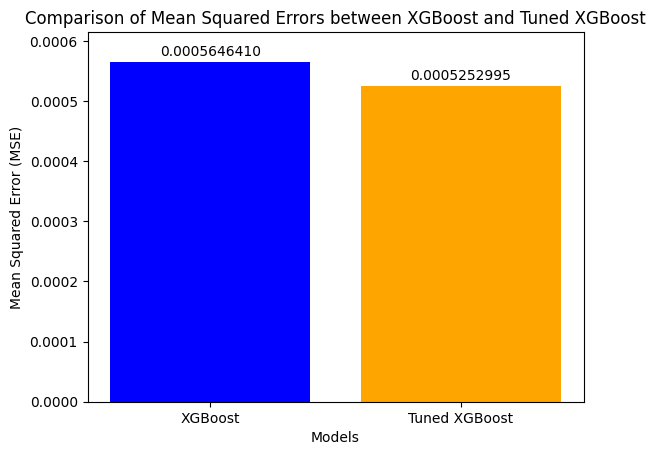

In [137]:
import matplotlib.pyplot as plt

# Assuming you have the MSE values stored in mse_sp500 and mse_sp500_tuned variables

# MSE values
mse_values = [mse_sp500, mse_sp500_tuned]

# Model names
model_names = ['XGBoost', 'Tuned XGBoost']

# Creating a bar plot
plt.bar(model_names, mse_values, color=['blue', 'orange'])
for i, value in enumerate(mse_values):
    plt.text(i, value + 0.000005, f'{value:.10f}', ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Errors between XGBoost and Tuned XGBoost')

# Adjusting the y-axis range
plt.ylim(0.00, max(mse_values) + 0.00005)

# Display the plot
plt.show()

In [142]:
#display the predicted price percentage change values with the actual price percentage change values
y_pred = sp500[1]
y_pred
y_test = sp500[3]
y_test_tuned = sp500_tuned[4]


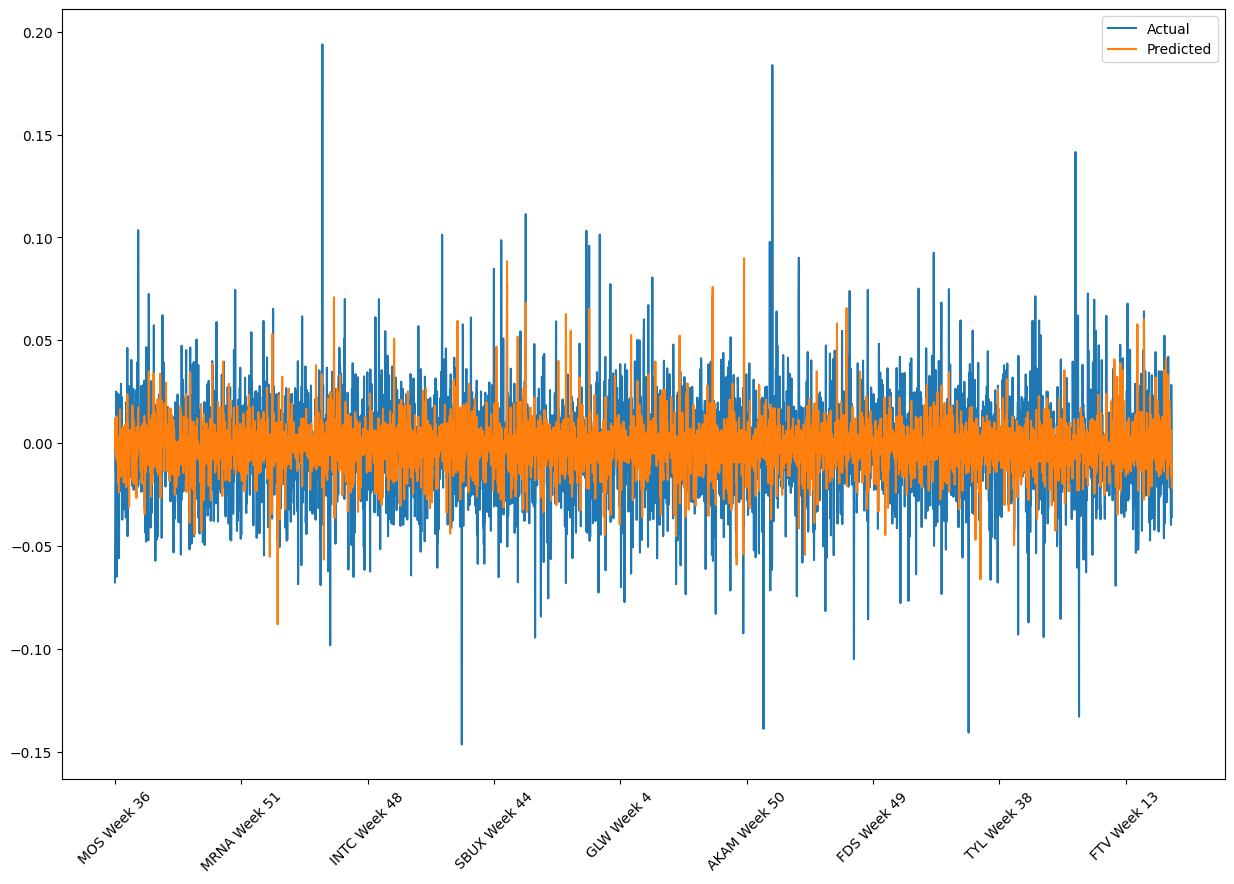

In [146]:
# plot the actual price percentage change values with the predicted price percentage change values
plt.figure(figsize=(15, 10))
plt.plot(y_test_tuned, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
# reduce the frequency of the x labels
plt.xticks(np.arange(0, len(y_test_tuned), 500))
plt.xticks(rotation=45)
plt.show()


In [ ]:
# plot the actual price percentage change values with the predicted price percentage change values
plt.figure(figsize=(15, 10))
plt.plot(y_test_tuned, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
# reduce the frequency of the x labels
plt.xticks(np.arange(0, len(y_test_tuned), 500))
# 
plt.xticks(rotation=45)
plt.show()

## <b>APPL

In [149]:
# run the APPL data through the model
APPL = APPL.astype('float64')
APPL


,Day 1,Day 2,Day 3,Day 4,Day 5
APPL Week 2,170.244827,173.102188,173.547104,170.244827,171.114914
APPL Week 4,159.794250,157.975006,157.886032,157.421356,168.405853
APPL Week 5,172.805557,172.637497,173.853592,170.946793,170.659714
APPL Week 6,169.937027,173.075241,174.510666,170.392441,166.947357
APPL Week 7,167.184967,171.055725,170.818130,167.184967,165.620819
APPL Week 9,163.462692,161.561966,164.888229,164.561554,161.532272
APPL Week 10,157.701111,155.859787,161.314484,156.928925,153.176971
APPL Week 11,149.108215,153.533371,157.988174,159.007828,162.334137
APPL Week 12,163.720093,167.125549,168.501587,172.322876,172.966339
APPL Week 13,173.837509,177.163788,175.985733,172.857452,172.560440


In [151]:
# run APPL through the model
y = APPL['Day 5']
X= APPL.drop(columns='Day 5')
APPL_model = train_xgboost_regressor(X,y)
APPL_mse = APPL_model[2]
APPL_mse

24.891835839487612

In [152]:
APPL_tuned = xgboost_tuned(X,y)
APPL_mse_tuned = APPL_tuned[2]
APPL_mse_tuned

29.253520582880203

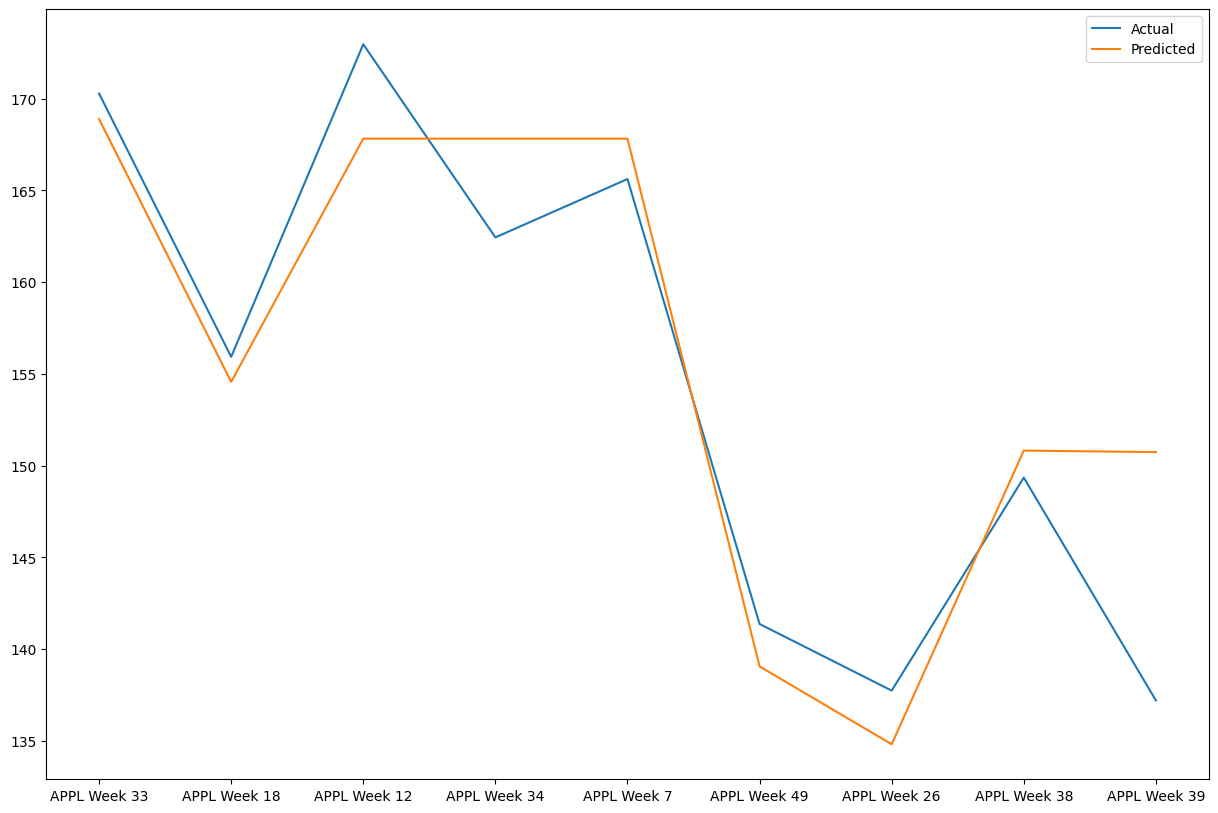

In [159]:
# plot the actual price percentage change values with the predicted price percentage change values for APPL
y_pred = APPL_model[1]
y_test = APPL_model[3]
y_pred_tuned = APPL_tuned[1]
y_test_tuned = APPL_tuned[4]
y_pred
plt.figure(figsize=(15, 10))
plt.plot(y_test_tuned, label='Actual')
plt.plot(y_pred_tuned, label='Predicted')
plt.legend()
plt.show()
